# Filtering Relevant Flood Images on Twitter using Content-based Filters

> Björn Barz, Kai Schröter, Ann-Christin Kra, and Joachim Denzler.  
> Workshop on "Machine Learning Advances Environmental Science (MAES)" at the "International Conference on Pattern Recognition (ICPR)" 2020.

This notebook illustrates the use of the pre-trained models for classifying whether a certain image is relevant for determining the presence of flooding, the inundation depth, and pollution.

In [1]:
import json
import os.path
from glob import glob

import numpy as np
import pandas as pd
import keras
import keras_preprocessing.image
import sklearn.metrics

import matplotlib.pyplot as plt
import IPython.display

from utils import load_and_crop_img, predict_with_orientation as predict
keras_preprocessing.image.iterator.load_img = load_and_crop_img  # patch image loading function from keras to support cropping

Using TensorFlow backend.


## Load Data

For this example, we will use the combined Harz17 + Rhine18 dataset. Make sure to have downloaded the images before using the provided script `download_images.py`.

We will load the annotations as well, so that we can evaluate the performance of the classifiers.

#### Load Annotations

In [2]:
classnames = ['Flooding', 'Depth', 'Pollution']
datasets = ['harz17', 'rhine18']

# Load annotations
annotations = {}
for ds in datasets:
    with open('{}.json'.format(ds)) as f:
        annotations.update(json.load(f))

# Determine set of relevant images for each class
twitter_rel = { classname : set() for classname in classnames }
for img_id, annot in annotations.items():
    for classname in classnames:
        if annot['Rel' +  classname]:
            twitter_rel[classname].add(img_id)

for classname, rel in twitter_rel.items():
    print('{}: {} relevant images'.format(classname, len(rel)))

Flooding: 1064 relevant images
Depth: 594 relevant images
Pollution: 12 relevant images


#### Construct List of Images

We also need to determine their orientation, since resizing will differ between images taken in landscape and portrait mode.

In [3]:
filenames = []
for ds in datasets:
    filenames += keras_preprocessing.image.list_pictures(ds)

data = pd.DataFrame({
    'filename' : filenames,
    'landscape' : [w >= h for fn in filenames for h, w, *_ in [plt.imread(fn).shape]]
})

print('Found {} images.'.format(len(data)))

Found 2552 images.


#### Set up Image Pre-processing

In [4]:
img_generator = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, featurewise_std_normalization=False,
    preprocessing_function=lambda img: img[:,:,::-1]  # RGB to BGR conversion
)
img_generator.mean = np.array([103.939, 116.779, 123.68])

## Load Model

We use ResNet-50 in this example. For VGG-16, replace `rn50` with `vgg16`.

In [5]:
model = keras.models.load_model('models/flood_relevance.rn50.h5', compile=False)
thresholds = np.array([-0.0677, -0.18, 0.011])  # Classification thresholds for the 3 classes for ResNet-50
#thresholds = np.array([-0.145, -0.2835, -0.1408])  # Classification thresholds for the 3 classes for VGG-16

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Prediction

#### Predict Class Probabilities

In [6]:
predictions = predict(model, img_generator, data)
predictions.shape

Found 2257 validated image filenames.
113/283 [==========>...................] - ETA: 29s

/home/barz/lib/anaconda3/envs/tf18/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


283/283 [==============================] - 43s 152ms/step
Found 295 validated image filenames.
37/37 [==============================] - 8s 227ms/step


(2552, 4)

The model has 4 outputs: One for each class and an additional one for the "irrelevant" class, which we ignore in the following.

#### Classify using Threshold

In [7]:
binary_predictions = (predictions[:, :3] > thresholds[None, :])

for classname, num_pred in zip(classnames, binary_predictions.sum(axis=0)):
    print('{} images classified as relevant for {}'.format(num_pred, classname))

490 images classified as relevant for Flooding
190 images classified as relevant for Depth
85 images classified as relevant for Pollution


## Evaluation

### Quantitative

Using the annotations provided with the Twitter dataset, we will compute precision-recall curves for varying thresholds and the area under that curve (*average precision*) as scalar performance metric.

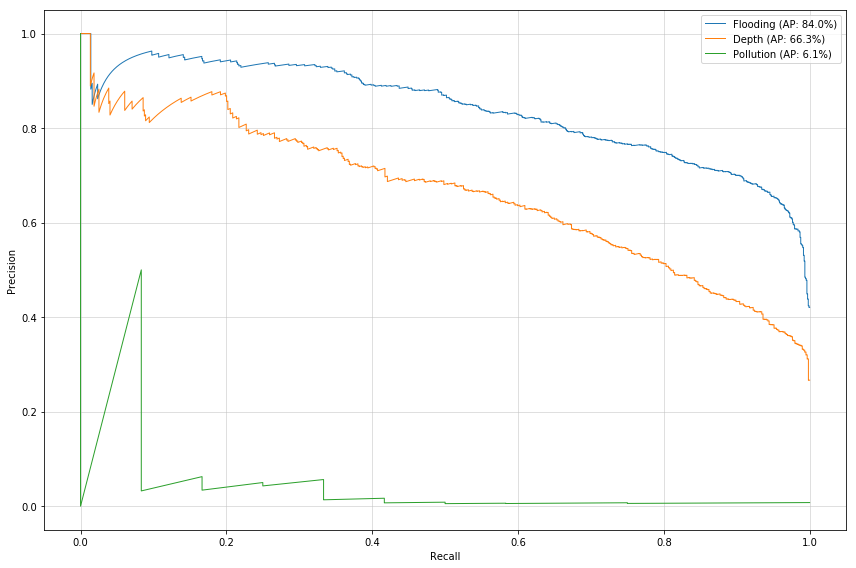

In [8]:
fig = plt.figure(figsize=(12, 8))

for ci, classname in enumerate(classnames):
    gt_labels = [(os.path.splitext(os.path.basename(fn))[0] in twitter_rel[classname]) for fn in data['filename']]
    precision, recall, _ = sklearn.metrics.precision_recall_curve(gt_labels, predictions[:, ci])
    ap = sklearn.metrics.average_precision_score(gt_labels, predictions[:, ci])
    plt.plot(recall, precision, label='{} (AP: {:.1%})'.format(classname, ap), linewidth=1)

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid(linewidth=.5, color='#c0c0c0')

plt.legend()
plt.tight_layout()
plt.show()

### Qualitative Examples

Here, we retrieve images from the Twitter datasets that obtain the highest predictive scores for each class.

True positives will be denoted with a green frame, false positives with a red one.

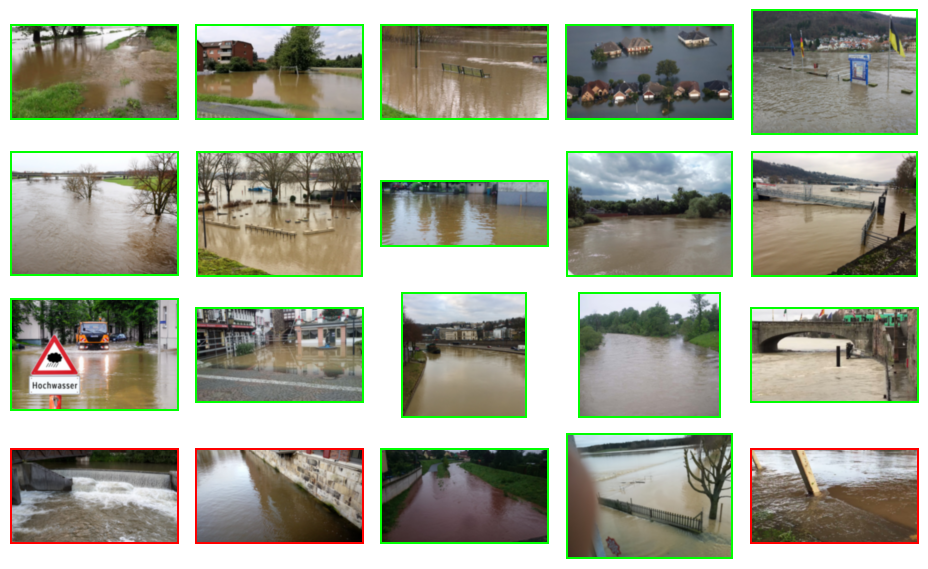

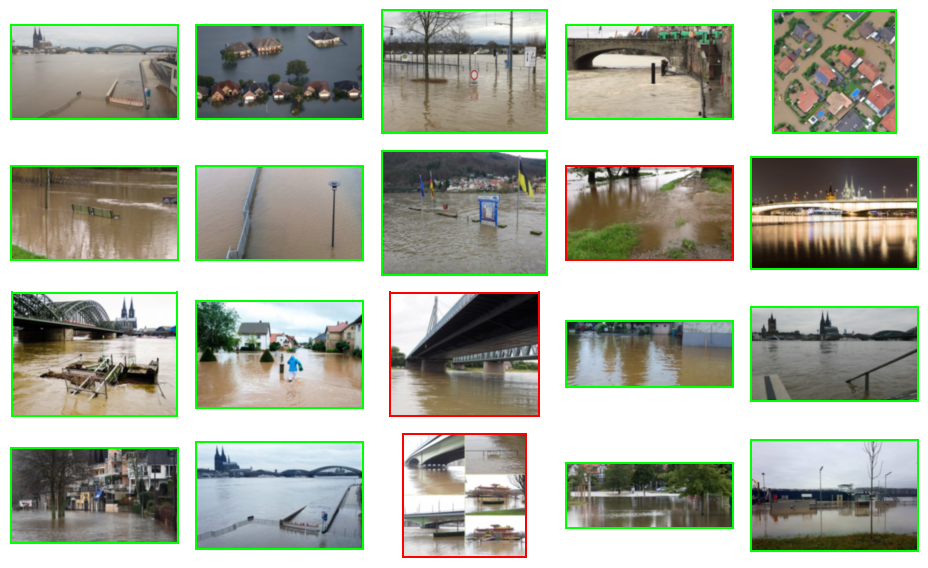

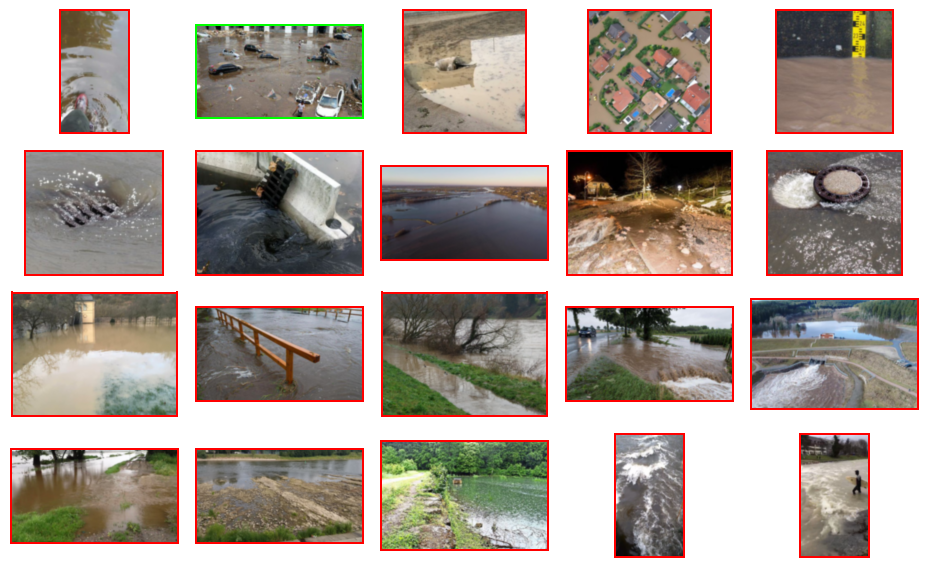

In [11]:
for classname, scores, th in zip(classnames, predictions.T, thresholds):

    IPython.display.display(IPython.display.HTML('<h5 style="text-align: center;">' + classname + '</h5>'))
    ret_ind = np.argsort(-scores)
    ret = np.asarray(data['filename'])[ret_ind]

    fig_rows = min(4, int(np.ceil(len(ret) / 5)))
    fig, axes = plt.subplots(fig_rows, 5, figsize=(13, 2 * fig_rows))
    for fn, ax in zip(ret, axes.ravel()):
        img_id = os.path.splitext(os.path.basename(fn))[0]
        ax.imshow(plt.imread(fn), interpolation='bicubic')
        ax.set_xticks([])
        ax.set_yticks([])
        if img_id in annotations:
            for pos in ['top', 'bottom', 'right', 'left']:
                ax.spines[pos].set_edgecolor('lime' if img_id in twitter_rel[classname] else 'red')
                ax.spines[pos].set_linewidth(2)
    fig.tight_layout()
    plt.show()